In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from rollout import *
from traj_utils import *

In [3]:
run_paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/*/run*/", recursive=True)
run_path = random.choice(run_paths)
run_path

'/media/ssd2/blender_membank_frameskip/dataloader_06/run_12/'

In [4]:
from loaders import RunLoader

In [5]:
%%time
run = RunLoader(run_path, is_rw=False)

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:316: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


(160, 360, 1440, 3) (160, 180, 120, 3) (160, 40) (160, 120)
CPU times: user 2.34 s, sys: 522 ms, total: 2.86 s
Wall time: 3.81 s


In [6]:
m = EffNet().to(device)
m.use_rnn = False
m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m{'5.25_e39'}.torch"))

<All keys matched successfully>

In [7]:
%%time
rollout = Rollout(run, "5.25_e39", m=m, store_imgs=True)

0


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


loader is done
Stopsign approaching! 59.12
Stopsign approaching! 56.87
Stopsign approaching! 53.62
Stopsign approaching! 49.58
Rollout complete!
CPU times: user 3.13 s, sys: 1.51 s, total: 4.64 s
Wall time: 5.34 s


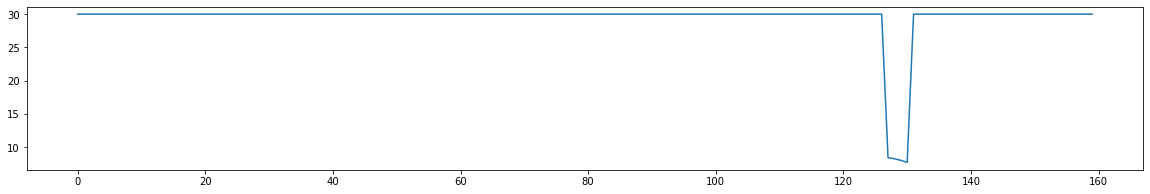

In [8]:
plt.figure(figsize=(20,3))
plt.plot(rollout.additional_results[:, "sss_p"])

In [9]:
make_enriched_vid_trn(rollout)

0
sim_5.25_e39 done!


In [522]:
linear_to_sin_decay(2)

1.0

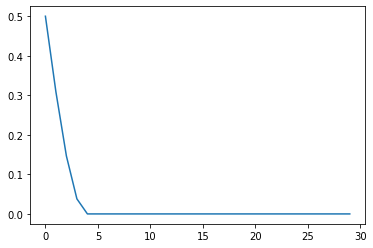

In [526]:
plt.plot(linear_to_sin_decay(np.clip(TRAJ_WP_DISTS_NP / 8, 0, 1)))

In [497]:
meters_to_undagger = 20
perc_into_undaggering = TRAJ_WP_DISTS_NP / meters_to_undagger 
p = np.clip(linear_to_sin_decay(perc_into_undaggering), 0, 1)

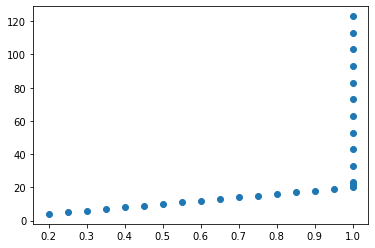

In [498]:
plt.scatter(np.clip(perc_into_undaggering, 0, 1), TRAJ_WP_DISTS_NP)

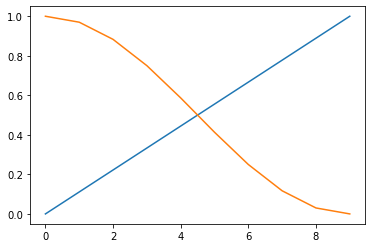

In [503]:
plt.plot(np.linspace(0,1,10))
plt.plot(linear_to_sin_decay(np.linspace(0,1,10)))

In [442]:
wp_angles, wp_dists, wp_rolls, wp_zs = np.split(run.targets_chunk, 4, axis=-1)

ix = 100
wp_angles = wp_angles[:,ix:ix+41,:]
wp_dists = wp_dists[:,ix:ix+41,:]
aux = run.aux_chunk[:,ix:ix+41,:]

In [443]:
xs, ys = xy_from_angle_dist(wp_angles, wp_dists)
t0_xs, t0_ys = xs[:,:-1], ys[:,:-1]
t1_xs, t1_ys = xs[:,1:], ys[:,1:]

# shift and rotate t1 according to vehicle motion. Using aux values (tire angle, speed) from t0
t1h, t1x, t1y = get_heading_and_pos_delta(((aux[:,:-1,'tire_angle']+aux[:,1:,'tire_angle'])/2)*.5, 
                                          (aux[:,:-1,'speed']+aux[:,1:,'speed'])/2, 
                                          wheelbase=CRV_WHEELBASE)

t1_xs += t1x[:,:,None]
t1_ys += t1y[:,:,None]

t1_xs, t1_ys = rotate_around_origin(t1_xs, t1_ys, t1h[:,:,None])

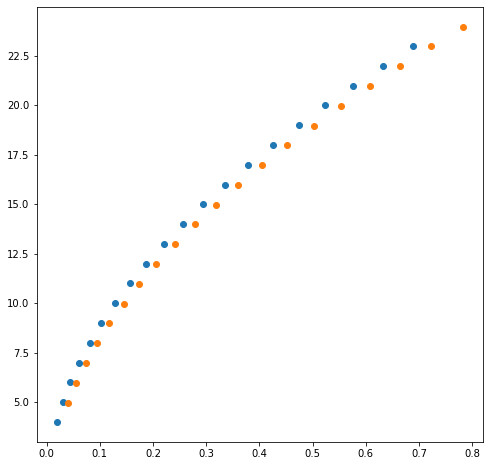

In [444]:
plt.figure(figsize=(8,8))
plt.scatter(t0_xs[0,0,:20], t0_ys[0,0,:20])
plt.scatter(t1_xs[0,0,:20], t1_ys[0,0,:20])

In [10]:
run.aux_chunk[0,:,"pos_x"].max()

NamedArray(0., dtype=float32)

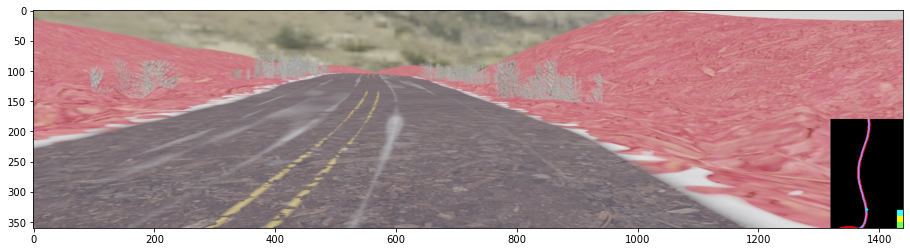

In [13]:
plt.figure(figsize=(20,4))
plt.imshow(run.img_chunk[0, ix, :,:,:3])

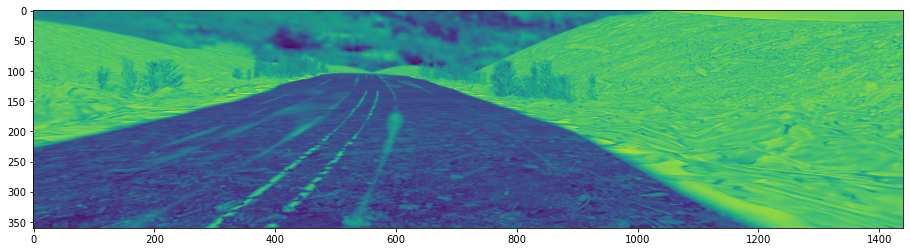

In [14]:
plt.figure(figsize=(20,4))
plt.imshow(run.img_chunk[0, ix, :,:,3:])

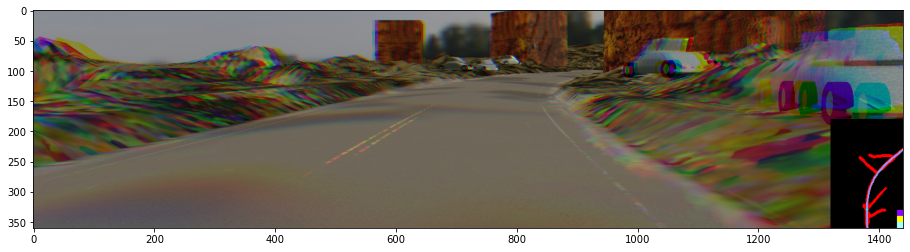

In [7]:
img = np.concatenate([run.img_chunk[0, ix, :,:,0:1], 
                      run.img_chunk[0, ix-1, :,:,1:2], 
                      run.img_chunk[0, ix-2, :,:,2:3]], axis=-1)
plt.figure(figsize=(20,4))
plt.imshow(img)

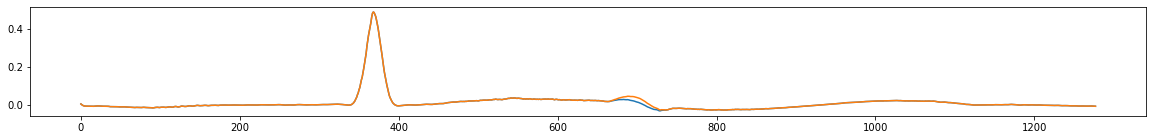

In [8]:
# steer
plt.figure(figsize=(20,2))
plt.plot(run.aux_chunk[0,:,'tire_angle'])
plt.plot(run.aux_chunk[0,:,'tire_angle_dagger_corrected'])

In [9]:
write_vid(run.img_chunk[0,:,:,:,:3], 'vid2')

vid2 done!


In [ ]:
plt.figure(figsize=(20,2))
plt.plot(run.aux_chunk[0,:,'speed'])

In [ ]:
list(EPISODE_PROPS)

In [16]:
%%time
rollout = Rollout(run, "1.18_e21")

0
loader is done
Rollout complete!
CPU times: user 27.4 s, sys: 3.44 s, total: 30.8 s
Wall time: 20.2 s


In [14]:
run.bptt = 64

In [15]:
run.reset()

In [ ]:
rollout.wps.shape

In [ ]:
calc_rollout_results(rollout)
flatten_rollout(rollout)

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(rollout.wps[:,0])
plt.plot(rollout.wps_p[:,0])

In [33]:
np.isnan(rollout.final_acts).sum()

1278

In [37]:
np.isnan(rollout.final_acts[0,:]).sum()

1

In [32]:
rollout.final_acts.shape

(1278, 1792)

In [38]:
m.train

NameError: name 'm' is not defined

In [10]:
%%time
rollout.assemble_frames()

Done assembling rollout frames!
CPU times: user 1min 2s, sys: 25.8 s, total: 1min 28s
Wall time: 28 s


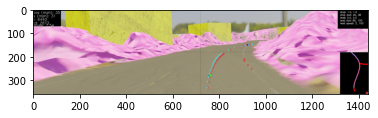

In [11]:
plt.imshow(rollout.img_rollout[10])

In [12]:
%%time
write_vid(rollout.img_rollout, f"{rollout.run_id}_{rollout.model_stem}")

sim_12.30_avg done!
CPU times: user 8.22 s, sys: 101 ms, total: 8.33 s
Wall time: 8.35 s


In [15]:
%%time
rollout_f = f"{BESPOKE_ROOT}/tmp/{run.run_id}_{rollout.model_stem}_rollout.pkl"
run_f = f"{BESPOKE_ROOT}/tmp/{run.run_id}_run.pkl"
save_object(rollout, rollout_f)

CPU times: user 7.07 s, sys: 1.79 s, total: 8.86 s
Wall time: 9.24 s


In [15]:
%%time
run = load_object(run_f)

CPU times: user 326 µs, sys: 1 s, total: 1 s
Wall time: 1 s


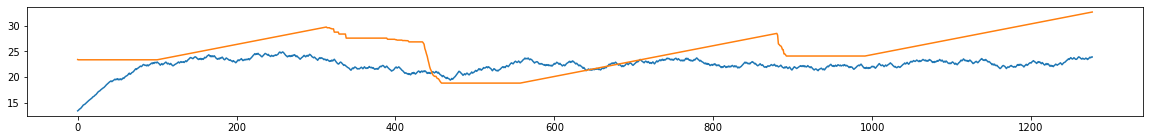

In [16]:
plt.figure(figsize=(20,2))
plt.plot(rollout.speed_mps)
plt.plot(rollout.ccs)

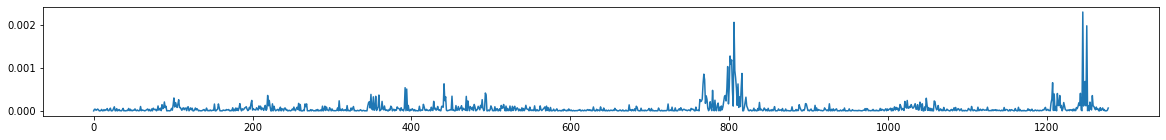

In [16]:
plt.figure(figsize=(20,2))
te = rollout.te
te = rollout.te / np.clip(np.abs(rollout.run.tire_angle), .01, np.inf)
te = np.clip(te, 0, .005)
plt.plot(te)

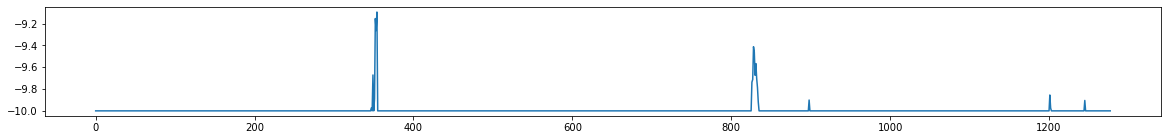

In [17]:
plt.figure(figsize=(20,2))
tl = rollout.tire_angle_loss
plt.plot(np.clip(np.log(tl), -10, 0))

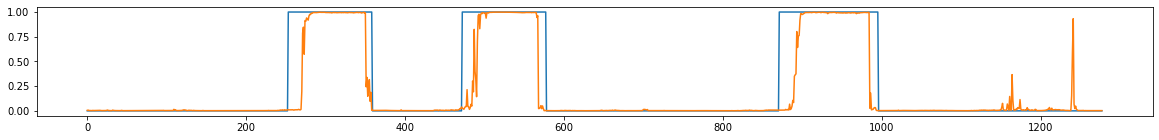

In [18]:
# Approaching stop

plt.figure(figsize=(20,2))
plt.plot(rollout.run.approaching_stop)
plt.plot(rollout.approaching_stop_p)

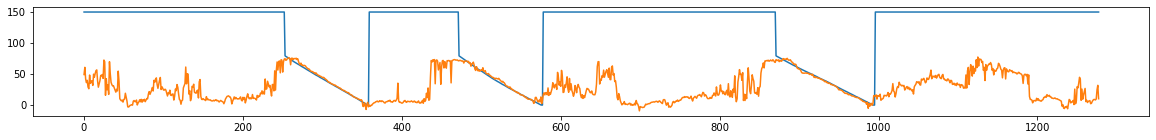

In [19]:
# stop dist
plt.figure(figsize=(20,2))
plt.plot(rollout.run.stop_dist)
plt.plot(rollout.stop_dist_p)

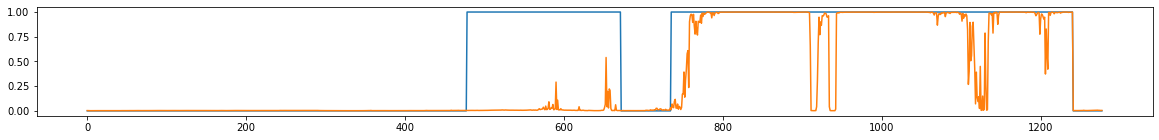

In [20]:
# has lead

plt.figure(figsize=(20,2))
plt.plot(rollout.run.has_lead)
plt.plot(rollout.has_lead_p)

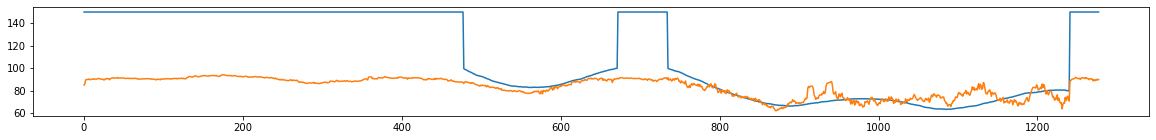

In [21]:
# lead dist

plt.figure(figsize=(20,2))
plt.plot(rollout.run.lead_dist)
plt.plot(rollout.lead_dist_p)

In [23]:
combine_vids("12.28_avg", "12.28_avg_1", "sim")

combined!


In [36]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [37]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

NameError: name 'rollout_data' is not defined

(array([ 262.,  382.,  354.,  193.,  881.,  984., 1261., 1231.,  211.,
          41.]),
 array([-6.6448742e-04, -5.0002674e-04, -3.3556606e-04, -1.7110539e-04,
        -6.6447187e-06,  1.5781596e-04,  3.2227664e-04,  4.8673732e-04,
         6.5119797e-04,  8.1565866e-04,  9.8011934e-04], dtype=float32),
 <BarContainer object of 10 artists>)

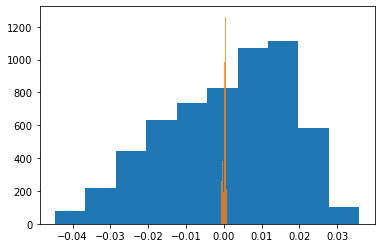

In [50]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

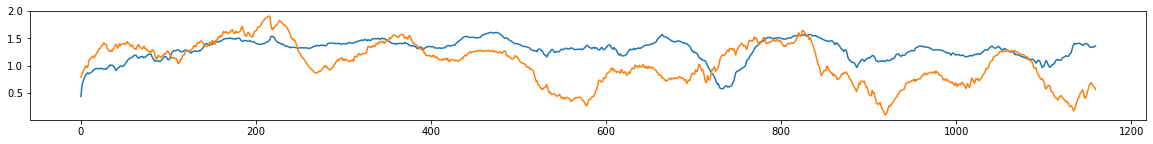

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)